Before starting change runtime type to GPU T4

Check if runtime is avialable. I fthis appear Num GPUs Available: 1 then good to go

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [1]:
!pip install rasterio
!pip install scikit-learn
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.0 MB/s eta 0:00:00


1: Import Libraries

In [3]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
from skimage.util import view_as_windows
import albumentations as A
import shutil

2: Load Multiband Raster and Label Raster

In [4]:
def load_raster(path):
    with rasterio.open(path) as src:
        array = src.read()
    return np.transpose(array, (1, 2, 0))

feature_stack = load_raster("/content/Composite.tif")
label_raster = load_raster("/content/cnn_labels_merged.tif")[..., 0]

3: Extract Image Patches

In [5]:
def extract_patches(img, label, patch_size=64, stride=64):
    """
    Extracts patches from the image and label arrays using a sliding window.
    """
    img_patches = view_as_windows(img, (patch_size, patch_size, img.shape[2]), step=stride)
    lbl_patches = view_as_windows(label, (patch_size, patch_size), step=stride)
    img_patches = img_patches.reshape(-1, patch_size, patch_size, img.shape[2])
    lbl_patches = lbl_patches.reshape(-1, patch_size, patch_size)
    return img_patches, lbl_patches

# Extract patches from stacked raster and label raster
X_patches, y_patches = extract_patches(feature_stack, label_raster)

# Save the number of patches extracted for reference
print(f"Extracted {len(X_patches)} image patches of size 64x64 from the raster stack.")
print(f"Extracted {len(y_patches)} image patches of size 64x64 from the raster stack.")

Extracted 1806 image patches of size 64x64 from the raster stack.
Extracted 1806 image patches of size 64x64 from the raster stack.


4: Filter Unusable Patches

In [6]:
def filter_patches(X, y):
    """
    Remove patches where the label patch contains only background (i.e., all zeros).
    """
    mask = np.array([np.any(label_patch > 0) for label_patch in y])
    X_filtered = X[mask]
    y_filtered = y[mask]
    print(f"Filtered out {len(X) - len(X_filtered)} background-only patches. Remaining: {len(X_filtered)}")
    return X_filtered, y_filtered

# Apply filtering to remove background-only patches
X_patches, y_patches = filter_patches(X_patches, y_patches)

Filtered out 1786 background-only patches. Remaining: 20


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import albumentations as A
from sklearn.model_selection import train_test_split

Apply data augmentation with transformations that preserve 64x64 dimensions.

In [8]:
def augment_patch(img, lbl):

    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=30, p=0.5),
        A.Resize(height=64, width=64, always_apply=True)
    ])
    augmented = aug(image=img, mask=lbl)
    return [img, augmented['image']], [lbl, augmented['mask']]


Apply augmentation with shape checks

In [9]:
X_aug, y_aug = [], []
for i in range(len(X_patches)):
    imgs, lbls = augment_patch(X_patches[i], y_patches[i])
    for img, lbl in zip(imgs, lbls):
        if img.shape != X_patches[0].shape or lbl.shape != y_patches[0].shape:
            print(f"Warning: Inconsistent shape at index {i}: img={img.shape}, lbl={lbl.shape}")
        X_aug.append(img)
        y_aug.append(lbl)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-8-a3563df3a4b4>:10: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=64, width=64, always_apply=True)


Convert to NumPy arrays

In [10]:
X_patches = np.array(X_aug)
y_patches = np.array(y_aug)
print(f"Data augmented. Total patches after augmentation: {len(X_patches)}")
print(f"X_patches shape: {X_patches.shape}")
print(f"y_patches shape: {y_patches.shape}")

Data augmented. Total patches after augmentation: 40
X_patches shape: (40, 64, 64, 15)
y_patches shape: (40, 64, 64)


Split dataset

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X_patches, y_patches, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 32, Validation: 4, Test: 4


Check for NaN/Inf

In [12]:
print("Checking for NaN/Inf in data...")
print("NaN in X_train:", np.any(np.isnan(X_train)))
print("Inf in X_train:", np.any(np.isinf(X_train)))
print("NaN in y_train:", np.any(np.isnan(y_train)))
print("Inf in y_train:", np.any(np.isinf(y_train)))
print("NaN in X_val:", np.any(np.isnan(X_val)))
print("Inf in X_val:", np.any(np.isinf(X_val)))
print("NaN in y_val:", np.any(np.isnan(y_val)))
print("Inf in y_val:", np.any(np.isinf(y_val)))


Checking for NaN/Inf in data...
NaN in X_train: False
Inf in X_train: False
NaN in y_train: True
Inf in y_train: False
NaN in X_val: False
Inf in X_val: False
NaN in y_val: True
Inf in y_val: False


Handle NaN in labels

In [13]:
y_train = np.nan_to_num(y_train, nan=0.0)
y_val = np.nan_to_num(y_val, nan=0.0)
print("NaN in y_train after fix:", np.any(np.isnan(y_train)))
print("NaN in y_val after fix:", np.any(np.isnan(y_val)))

NaN in y_train after fix: False
NaN in y_val after fix: False


Normalize inputs

In [14]:
X_train = X_train / np.max(X_train) if np.max(X_train) > 0 else X_train
X_val = X_val / np.max(X_val) if np.max(X_val) > 0 else X_val

Ensure binary labels and add channel dimension

In [15]:
print("Unique values in y_train before binarization:", np.unique(y_train))
y_train = (y_train > 0).astype(np.float32)
y_val = (y_val > 0).astype(np.float32)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
print("Unique values in y_train after binarization:", np.unique(y_train))
print("Unique values in y_val after binarization:", np.unique(y_val))

Unique values in y_train before binarization: [0. 1.]
Unique values in y_train after binarization: [0. 1.]
Unique values in y_val after binarization: [0. 1.]


Clip data

In [16]:
X_train = np.clip(X_train, 0, 1)
X_val = np.clip(X_val, 0, 1)
y_train = np.clip(y_train, 0, 1)
y_val = np.clip(y_val, 0, 1)

Check shapes

In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (32, 64, 64, 15)
y_train shape: (32, 64, 64, 1)
X_val shape: (4, 64, 64, 15)
y_val shape: (4, 64, 64, 1)


Check class distribution

In [18]:
print("Proportion of positive class in y_train:", np.mean(y_train > 0))
print("Proportion of positive class in y_val:", np.mean(y_val > 0))

Proportion of positive class in y_train: 0.242034912109375
Proportion of positive class in y_val: 0.38079833984375


Define class weights

In [19]:
positive_ratio = np.mean(y_train > 0)
class_weights = {0: 1.0, 1: min(1.0 / positive_ratio, 50.0) if positive_ratio > 0 else 1.0}
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: np.float64(4.131635354936326)}


Corrected weighted binary cross-entropy loss

In [20]:
def weighted_binary_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    weights = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
    weighted_loss = bce * weights
    return tf.reduce_mean(weighted_loss, axis=[1, 2, 3])

IoU metric

In [21]:
def iou_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

U-Net model with regularization

In [22]:
def build_unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c4)
    c4 = layers.Dropout(0.3)(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c5)
    c5 = layers.Dropout(0.3)(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c6)
    c6 = layers.Dropout(0.3)(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c7)
    c7 = layers.Dropout(0.3)(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    return models.Model(inputs=[inputs], outputs=[outputs])

Build and compile model

In [25]:
input_shape = (64, 64, X_train.shape[-1])
model = build_unet_model(input_shape, num_classes=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=weighted_binary_crossentropy,
              metrics=['accuracy', iou_metric])

Train with callbacks

In [26]:
checkpoint = callbacks.ModelCheckpoint("unet_model.h5", save_best_only=True)
earlystop = callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_iou_metric', mode='max')
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[checkpoint, earlystop, lr_scheduler]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 64, 64, 15))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5651 - iou_metric: 0.1627 - loss: 28.0555

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 64, 64, 15))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5507 - iou_metric: 0.1689 - loss: 28.0201 - val_accuracy: 0.4144 - val_iou_metric: 0.3906 - val_loss: 27.5551 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3215 - iou_metric: 0.2402 - loss: 27.1055

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.3184 - iou_metric: 0.2405 - loss: 27.0715 - val_accuracy: 0.3930 - val_iou_metric: 0.3852 - val_loss: 26.6098 - learning_rate: 1.0000e-04
Epoch 3/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2669 - iou_metric: 0.2385 - loss: 26.2337

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.2683 - iou_metric: 0.2410 - loss: 26.1479 - val_accuracy: 0.3857 - val_iou_metric: 0.3826 - val_loss: 25.6982 - learning_rate: 1.0000e-04
Epoch 4/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2486 - iou_metric: 0.2325 - loss: 25.3356

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.2539 - iou_metric: 0.2373 - loss: 25.2539 - val_accuracy: 0.3839 - val_iou_metric: 0.3820 - val_loss: 24.8167 - learning_rate: 1.0000e-04
Epoch 5/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2775 - iou_metric: 0.2641 - loss: 24.5161 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.2696 - iou_metric: 0.2562 - loss: 24.4184 - val_accuracy: 0.3821 - val_iou_metric: 0.3813 - val_loss: 23.9561 - learning_rate: 1.0000e-04
Epoch 6/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2687 - iou_metric: 0.2607 - loss: 23.6758 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.2630 - iou_metric: 0.2540 - loss: 23.5812 - val_accuracy: 0.3820 - val_iou_metric: 0.3812 - val_loss: 23.1333 - learning_rate: 1.0000e-04
Epoch 7/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2503 - iou_metric: 0.2378 - loss: 22.8246

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.2535 - iou_metric: 0.2409 - loss: 22.7490 - val_accuracy: 0.3824 - val_iou_metric: 0.3814 - val_loss: 22.3448 - learning_rate: 1.0000e-04
Epoch 8/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2142 - iou_metric: 0.2015 - loss: 21.9936 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.2378 - iou_metric: 0.2209 - loss: 21.9403 - val_accuracy: 0.3842 - val_iou_metric: 0.3821 - val_loss: 21.5943 - learning_rate: 1.0000e-04
Epoch 9/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2436 - iou_metric: 0.2130 - loss: 21.2396

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2617 - iou_metric: 0.2289 - loss: 21.1884 - val_accuracy: 0.3926 - val_iou_metric: 0.3854 - val_loss: 20.8621 - learning_rate: 1.0000e-04
Epoch 10/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2986 - iou_metric: 0.2598 - loss: 20.5792 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.2981 - iou_metric: 0.2578 - loss: 20.5034 - val_accuracy: 0.4056 - val_iou_metric: 0.3905 - val_loss: 20.1496 - learning_rate: 1.0000e-04
Epoch 11/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3161 - iou_metric: 0.2638 - loss: 19.8791 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.3142 - iou_metric: 0.2610 - loss: 19.8052 - val_accuracy: 0.4132 - val_iou_metric: 0.3935 - val_loss: 19.4751 - learning_rate: 1.0000e-04
Epoch 12/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2996 - iou_metric: 0.2587 - loss: 19.2028

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.3172 - iou_metric: 0.2617 - loss: 19.1307 - val_accuracy: 0.4191 - val_iou_metric: 0.3959 - val_loss: 18.8254 - learning_rate: 1.0000e-04
Epoch 13/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3537 - iou_metric: 0.3138 - loss: 18.6292 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3517 - iou_metric: 0.2932 - loss: 18.5292 - val_accuracy: 0.4183 - val_iou_metric: 0.3956 - val_loss: 18.1798 - learning_rate: 1.0000e-04
Epoch 14/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3891 - iou_metric: 0.2759 - loss: 17.8811 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.3789 - iou_metric: 0.2751 - loss: 17.8304 - val_accuracy: 0.4293 - val_iou_metric: 0.3998 - val_loss: 17.5915 - learning_rate: 1.0000e-04
Epoch 15/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3974 - iou_metric: 0.2851 - loss: 17.3118

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.3998 - iou_metric: 0.2835 - loss: 17.2488 - val_accuracy: 0.4395 - val_iou_metric: 0.4032 - val_loss: 17.0175 - learning_rate: 1.0000e-04
Epoch 16/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3875 - iou_metric: 0.2728 - loss: 16.7053 

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 909ms/step - accuracy: 0.4017 - iou_metric: 0.2775 - loss: 16.6538 - val_accuracy: 0.4405 - val_iou_metric: 0.4036 - val_loss: 16.4485 - learning_rate: 1.0000e-04
Epoch 17/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4437 - iou_metric: 0.2793 - loss: 16.1353

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.4336 - iou_metric: 0.2817 - loss: 16.0888 - val_accuracy: 0.4393 - val_iou_metric: 0.4034 - val_loss: 15.8984 - learning_rate: 1.0000e-04
Epoch 18/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4828 - iou_metric: 0.3388 - loss: 15.6460 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4528 - iou_metric: 0.3182 - loss: 15.5820 - val_accuracy: 0.4357 - val_iou_metric: 0.4024 - val_loss: 15.3610 - learning_rate: 1.0000e-04
Epoch 19/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4461 - iou_metric: 0.3497 - loss: 15.1774 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4327 - iou_metric: 0.3260 - loss: 15.0941 - val_accuracy: 0.4509 - val_iou_metric: 0.4014 - val_loss: 14.8976 - learning_rate: 1.0000e-04
Epoch 20/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4711 - iou_metric: 0.2929 - loss: 14.5904 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4728 - iou_metric: 0.2960 - loss: 14.5437 - val_accuracy: 0.4470 - val_iou_metric: 0.3893 - val_loss: 14.4308 - learning_rate: 1.0000e-04
Epoch 21/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4483 - iou_metric: 0.2848 - loss: 14.1009

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.4561 - iou_metric: 0.2860 - loss: 14.0582 - val_accuracy: 0.4512 - val_iou_metric: 0.4004 - val_loss: 13.9479 - learning_rate: 1.0000e-04
Epoch 22/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4895 - iou_metric: 0.3370 - loss: 13.7083

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.4694 - iou_metric: 0.3184 - loss: 13.6400 - val_accuracy: 0.4370 - val_iou_metric: 0.4029 - val_loss: 13.4537 - learning_rate: 1.0000e-04
Epoch 23/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3959 - iou_metric: 0.2602 - loss: 13.1775 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4104 - iou_metric: 0.2721 - loss: 13.1437 - val_accuracy: 0.4471 - val_iou_metric: 0.4000 - val_loss: 13.0606 - learning_rate: 1.0000e-04
Epoch 24/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4365 - iou_metric: 0.3005 - loss: 12.8564

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4504 - iou_metric: 0.2957 - loss: 12.7778 - val_accuracy: 0.4437 - val_iou_metric: 0.3605 - val_loss: 12.7020 - learning_rate: 1.0000e-04
Epoch 25/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5390 - iou_metric: 0.2567 - loss: 12.3449 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5317 - iou_metric: 0.2671 - loss: 12.3116 - val_accuracy: 0.4482 - val_iou_metric: 0.3879 - val_loss: 12.2755 - learning_rate: 1.0000e-04
Epoch 26/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4549 - iou_metric: 0.2986 - loss: 11.9766 

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4667 - iou_metric: 0.2989 - loss: 11.9279 - val_accuracy: 0.4425 - val_iou_metric: 0.3929 - val_loss: 11.8716 - learning_rate: 1.0000e-04
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5141 - iou_metric: 0.3179 - loss: 11.5247

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.5090 - iou_metric: 0.3142 - loss: 11.5150 - val_accuracy: 0.4453 - val_iou_metric: 0.3849 - val_loss: 11.5226 - learning_rate: 1.0000e-04
Epoch 28/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5691 - iou_metric: 0.3004 - loss: 11.1155 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5510 - iou_metric: 0.3011 - loss: 11.1153 - val_accuracy: 0.4458 - val_iou_metric: 0.3827 - val_loss: 11.1673 - learning_rate: 1.0000e-04
Epoch 29/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4714 - iou_metric: 0.2855 - loss: 10.8478 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.4754 - iou_metric: 0.2934 - loss: 10.8102 - val_accuracy: 0.4499 - val_iou_metric: 0.3841 - val_loss: 10.8270 - learning_rate: 1.0000e-04
Epoch 30/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5416 - iou_metric: 0.3148 - loss: 10.4659

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5385 - iou_metric: 0.3132 - loss: 10.4477 - val_accuracy: 0.4545 - val_iou_metric: 0.3999 - val_loss: 10.4759 - learning_rate: 1.0000e-04
Epoch 31/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4980 - iou_metric: 0.3421 - loss: 10.2087

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.4995 - iou_metric: 0.3299 - loss: 10.1575 - val_accuracy: 0.4371 - val_iou_metric: 0.3436 - val_loss: 10.2338 - learning_rate: 1.0000e-04
Epoch 32/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6259 - iou_metric: 0.3856 - loss: 9.8115 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6008 - iou_metric: 0.3622 - loss: 9.7918 - val_accuracy: 0.4384 - val_iou_metric: 0.3331 - val_loss: 9.9501 - learning_rate: 1.0000e-04
Epoch 33/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5213 - iou_metric: 0.3588 - loss: 9.5860

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.5113 - iou_metric: 0.3394 - loss: 9.5413 - val_accuracy: 0.4476 - val_iou_metric: 0.3316 - val_loss: 9.6777 - learning_rate: 1.0000e-04
Epoch 34/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6041 - iou_metric: 0.3538 - loss: 9.2396

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5945 - iou_metric: 0.3322 - loss: 9.2280 - val_accuracy: 0.4365 - val_iou_metric: 0.4032 - val_loss: 9.2087 - learning_rate: 1.0000e-04
Epoch 35/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4947 - iou_metric: 0.3104 - loss: 8.9047

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.4557 - iou_metric: 0.3023 - loss: 8.9279 - val_accuracy: 0.4280 - val_iou_metric: 0.3997 - val_loss: 8.9463 - learning_rate: 1.0000e-04
Epoch 36/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3597 - iou_metric: 0.2495 - loss: 8.7569 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3816 - iou_metric: 0.2686 - loss: 8.7312 - val_accuracy: 0.4744 - val_iou_metric: 0.4195 - val_loss: 8.7352 - learning_rate: 1.0000e-04
Epoch 37/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4583 - iou_metric: 0.2823 - loss: 8.4362

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4923 - iou_metric: 0.3001 - loss: 8.4213 - val_accuracy: 0.4858 - val_iou_metric: 0.3342 - val_loss: 8.6695 - learning_rate: 1.0000e-04
Epoch 38/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6579 - iou_metric: 0.3670 - loss: 8.1756

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step - accuracy: 0.6331 - iou_metric: 0.3522 - loss: 8.1675 - val_accuracy: 0.4846 - val_iou_metric: 0.4166 - val_loss: 8.2776 - learning_rate: 1.0000e-04
Epoch 39/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4691 - iou_metric: 0.3024 - loss: 7.9902

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4853 - iou_metric: 0.3119 - loss: 7.9569 - val_accuracy: 0.4736 - val_iou_metric: 0.4176 - val_loss: 8.0188 - learning_rate: 1.0000e-04
Epoch 40/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5023 - iou_metric: 0.3091 - loss: 7.7553 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5251 - iou_metric: 0.3193 - loss: 7.7238 - val_accuracy: 0.4847 - val_iou_metric: 0.3413 - val_loss: 7.9544 - learning_rate: 1.0000e-04
Epoch 41/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6271 - iou_metric: 0.3434 - loss: 7.4979

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6081 - iou_metric: 0.3431 - loss: 7.4787 - val_accuracy: 0.4858 - val_iou_metric: 0.4208 - val_loss: 7.5733 - learning_rate: 1.0000e-04
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5680 - iou_metric: 0.3649 - loss: 7.2404 - val_accuracy: 0.5218 - val_iou_metric: 0.3231 - val_loss: 7.6025 - learning_rate: 1.0000e-04
Epoch 43/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5507 - iou_metric: 0.3508 - loss: 7.1597 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.5665 - iou_metric: 0.3463 - loss: 7.1034 - val_accuracy: 0.5135 - val_iou_metric: 0.4329 - val_loss: 7.1421 - learning_rate: 1.0000e-04
Epoch 44/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4802 - iou_metric: 0.3254 - loss: 6.9423

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.5152 - iou_metric: 0.3419 - loss: 6.8925 - val_accuracy: 0.5811 - val_iou_metric: 0.4189 - val_loss: 7.0451 - learning_rate: 1.0000e-04
Epoch 45/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6876 - iou_metric: 0.4057 - loss: 6.5316

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 923ms/step - accuracy: 0.6753 - iou_metric: 0.3964 - loss: 6.5663 - val_accuracy: 0.5134 - val_iou_metric: 0.4389 - val_loss: 6.6966 - learning_rate: 1.0000e-04
Epoch 46/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5062 - iou_metric: 0.3428 - loss: 6.5203

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.5018 - iou_metric: 0.3375 - loss: 6.5150 - val_accuracy: 0.6276 - val_iou_metric: 0.4724 - val_loss: 6.5613 - learning_rate: 1.0000e-04
Epoch 47/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6045 - iou_metric: 0.2939 - loss: 6.3730 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.6076 - iou_metric: 0.3102 - loss: 6.3494 - val_accuracy: 0.5333 - val_iou_metric: 0.4489 - val_loss: 6.3442 - learning_rate: 1.0000e-04
Epoch 48/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5272 - iou_metric: 0.3387 - loss: 6.1677 - val_accuracy: 0.6227 - val_iou_metric: 0.3754 - val_loss: 6.4485 - learning_rate: 1.0000e-04
Epoch 49/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6958 - iou_metric: 0.3680 - loss: 6.0293 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6917 - iou_metric: 0.3795 - loss: 5.9972 - val_accuracy: 0.5603 - val_iou_metric: 0.4627 - val_loss: 6.0214 - learning_rate: 1.0000e-04
Epoch 50/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5347 - iou_metric: 0.3514 - loss: 5.8485 - val_accuracy: 0.6641 - val_iou_metric: 0.4229 - val_loss: 6.0981 - learning_rate: 1.0000e-04
Epoch 51/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7473 - iou_metric: 0.3866 - loss: 5.6341

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7417 - iou_metric: 0.3961 - loss: 5.6235 - val_accuracy: 0.5909 - val_iou_metric: 0.4799 - val_loss: 5.6820 - learning_rate: 1.0000e-04
Epoch 52/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5635 - iou_metric: 0.3688 - loss: 5.5307 - val_accuracy: 0.6888 - val_iou_metric: 0.3956 - val_loss: 5.8668 - learning_rate: 1.0000e-04
Epoch 53/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7683 - iou_metric: 0.4536 - loss: 5.3668 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.7540 - iou_metric: 0.4446 - loss: 5.3415 - val_accuracy: 0.6552 - val_iou_metric: 0.5194 - val_loss: 5.3519 - learning_rate: 1.0000e-04
Epoch 54/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6907 - iou_metric: 0.4505 - loss: 5.1750 - val_accuracy: 0.7178 - val_iou_metric: 0.4624 - val_loss: 5.5170 - learning_rate: 1.0000e-04
Epoch 55/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7588 - iou_metric: 0.4520 - loss: 5.0661

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7243 - iou_metric: 0.4326 - loss: 5.0605 - val_accuracy: 0.6821 - val_iou_metric: 0.5371 - val_loss: 5.0770 - learning_rate: 1.0000e-04
Epoch 56/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7252 - iou_metric: 0.4429 - loss: 4.8840

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7417 - iou_metric: 0.4600 - loss: 4.8711 - val_accuracy: 0.6901 - val_iou_metric: 0.5430 - val_loss: 4.9529 - learning_rate: 1.0000e-04
Epoch 57/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7133 - iou_metric: 0.4577 - loss: 4.7672 - val_accuracy: 0.6973 - val_iou_metric: 0.4777 - val_loss: 5.0878 - learning_rate: 1.0000e-04
Epoch 58/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7606 - iou_metric: 0.4840 - loss: 4.6037 - val_accuracy: 0.7166 - val_iou_metric: 0.4829 - val_loss: 4.9962 - learning_rate: 1.0000e-04
Epoch 59/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7569 - iou_metric: 0.3973 - loss: 4.6638

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.7583 - iou_metric: 0.4227 - loss: 4.6014 - val_accuracy: 0.7417 - val_iou_metric: 0.5659 - val_loss: 4.6638 - learning_rate: 1.0000e-04
Epoch 60/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7932 - iou_metric: 0.4997 - loss: 4.3848

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.7727 - iou_metric: 0.4891 - loss: 4.3928 - val_accuracy: 0.7090 - val_iou_metric: 0.5617 - val_loss: 4.4436 - learning_rate: 1.0000e-04
Epoch 61/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7427 - iou_metric: 0.4821 - loss: 4.3175 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7631 - iou_metric: 0.4949 - loss: 4.3007 - val_accuracy: 0.6788 - val_iou_metric: 0.5399 - val_loss: 4.3738 - learning_rate: 1.0000e-04
Epoch 62/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6753 - iou_metric: 0.4145 - loss: 4.2605 - val_accuracy: 0.7249 - val_iou_metric: 0.5310 - val_loss: 4.4375 - learning_rate: 1.0000e-04
Epoch 63/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8309 - iou_metric: 0.5922 - loss: 4.0376

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8266 - iou_metric: 0.5773 - loss: 4.0285 - val_accuracy: 0.7293 - val_iou_metric: 0.5785 - val_loss: 4.1436 - learning_rate: 1.0000e-04
Epoch 64/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8187 - iou_metric: 0.5555 - loss: 3.8901 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8174 - iou_metric: 0.5559 - loss: 3.9009 - val_accuracy: 0.7571 - val_iou_metric: 0.5864 - val_loss: 4.1281 - learning_rate: 1.0000e-04
Epoch 65/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7991 - iou_metric: 0.5490 - loss: 3.8677 - val_accuracy: 0.7372 - val_iou_metric: 0.5341 - val_loss: 4.2477 - learning_rate: 1.0000e-04
Epoch 66/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8225 - iou_metric: 0.5115 - loss: 3.8092

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.8196 - iou_metric: 0.5253 - loss: 3.7894 - val_accuracy: 0.7078 - val_iou_metric: 0.5624 - val_loss: 3.9030 - learning_rate: 1.0000e-04
Epoch 67/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7458 - iou_metric: 0.4709 - loss: 3.7483 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7670 - iou_metric: 0.4985 - loss: 3.7357 - val_accuracy: 0.7282 - val_iou_metric: 0.5809 - val_loss: 3.7961 - learning_rate: 1.0000e-04
Epoch 68/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7529 - iou_metric: 0.4919 - loss: 3.6945 - val_accuracy: 0.7573 - val_iou_metric: 0.5805 - val_loss: 3.8386 - learning_rate: 1.0000e-04
Epoch 69/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8220 - iou_metric: 0.5034 - loss: 3.5401

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7880 - iou_metric: 0.4916 - loss: 3.5780 - val_accuracy: 0.7006 - val_iou_metric: 0.5547 - val_loss: 3.7341 - learning_rate: 1.0000e-04
Epoch 70/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7614 - iou_metric: 0.4758 - loss: 3.6222

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.7668 - iou_metric: 0.4803 - loss: 3.6288 - val_accuracy: 0.6808 - val_iou_metric: 0.5425 - val_loss: 3.6682 - learning_rate: 1.0000e-04
Epoch 71/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6730 - iou_metric: 0.4369 - loss: 3.5617 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6572 - iou_metric: 0.4220 - loss: 3.5835 - val_accuracy: 0.7349 - val_iou_metric: 0.5725 - val_loss: 3.6201 - learning_rate: 1.0000e-04
Epoch 72/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7726 - iou_metric: 0.4743 - loss: 3.4743 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7859 - iou_metric: 0.4875 - loss: 3.4653 - val_accuracy: 0.7385 - val_iou_metric: 0.5865 - val_loss: 3.5187 - learning_rate: 1.0000e-04
Epoch 73/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7644 - iou_metric: 0.5096 - loss: 3.3322 - val_accuracy: 0.7415 - val_iou_metric: 0.5757 - val_loss: 3.5353 - learning_rate: 1.0000e-04
Epoch 74/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8258 - iou_metric: 0.5388 - loss: 3.2608 

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 890ms/step - accuracy: 0.8322 - iou_metric: 0.5524 - loss: 3.2723 - val_accuracy: 0.7432 - val_iou_metric: 0.5801 - val_loss: 3.4602 - learning_rate: 1.0000e-04
Epoch 75/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7909 - iou_metric: 0.5009 - loss: 3.1562

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7806 - iou_metric: 0.4975 - loss: 3.1711 - val_accuracy: 0.7593 - val_iou_metric: 0.6072 - val_loss: 3.3172 - learning_rate: 1.0000e-04
Epoch 76/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8054 - iou_metric: 0.5646 - loss: 3.1521 - val_accuracy: 0.7887 - val_iou_metric: 0.6158 - val_loss: 3.3431 - learning_rate: 1.0000e-04
Epoch 77/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8618 - iou_metric: 0.6228 - loss: 2.9863

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.8514 - iou_metric: 0.6179 - loss: 3.0024 - val_accuracy: 0.7704 - val_iou_metric: 0.6154 - val_loss: 3.1953 - learning_rate: 1.0000e-04
Epoch 78/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8359 - iou_metric: 0.5957 - loss: 2.9742 - val_accuracy: 0.7701 - val_iou_metric: 0.5847 - val_loss: 3.3048 - learning_rate: 1.0000e-04
Epoch 79/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8680 - iou_metric: 0.6019 - loss: 2.8672 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8584 - iou_metric: 0.5977 - loss: 2.8878 - val_accuracy: 0.7414 - val_iou_metric: 0.5934 - val_loss: 3.0989 - learning_rate: 1.0000e-04
Epoch 80/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7717 - iou_metric: 0.5252 - loss: 2.9309 - val_accuracy: 0.7562 - val_iou_metric: 0.5313 - val_loss: 3.5339 - learning_rate: 1.0000e-04
Epoch 81/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8446 - iou_metric: 0.5543 - loss: 2.9530

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8312 - iou_metric: 0.5501 - loss: 2.9363 - val_accuracy: 0.7219 - val_iou_metric: 0.5767 - val_loss: 3.0319 - learning_rate: 1.0000e-04
Epoch 82/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7724 - iou_metric: 0.4827 - loss: 2.8739

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7836 - iou_metric: 0.4924 - loss: 2.8991 - val_accuracy: 0.7595 - val_iou_metric: 0.6032 - val_loss: 2.9772 - learning_rate: 1.0000e-04
Epoch 83/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7589 - iou_metric: 0.5157 - loss: 2.8490 - val_accuracy: 0.7224 - val_iou_metric: 0.5485 - val_loss: 3.1247 - learning_rate: 1.0000e-04
Epoch 84/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8424 - iou_metric: 0.5690 - loss: 2.7194 - val_accuracy: 0.7234 - val_iou_metric: 0.5616 - val_loss: 3.0094 - learning_rate: 1.0000e-04
Epoch 85/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7128 - iou_metric: 0.4445 - loss: 2.8164

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7049 - iou_metric: 0.4417 - loss: 2.8319 - val_accuracy: 0.7078 - val_iou_metric: 0.5643 - val_loss: 2.8961 - learning_rate: 1.0000e-04
Epoch 86/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7982 - iou_metric: 0.5081 - loss: 2.7200 - val_accuracy: 0.7660 - val_iou_metric: 0.5661 - val_loss: 3.0362 - learning_rate: 1.0000e-04
Epoch 87/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8556 - iou_metric: 0.6091 - loss: 2.5922 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.8449 - iou_metric: 0.6010 - loss: 2.5934 - val_accuracy: 0.7524 - val_iou_metric: 0.5994 - val_loss: 2.8031 - learning_rate: 1.0000e-04
Epoch 88/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8220 - iou_metric: 0.5857 - loss: 2.5549 - val_accuracy: 0.7678 - val_iou_metric: 0.5890 - val_loss: 2.9131 - learning_rate: 1.0000e-04
Epoch 89/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8339 - iou_metric: 0.5989 - loss: 2.5854

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8272 - iou_metric: 0.5826 - loss: 2.5739 - val_accuracy: 0.7665 - val_iou_metric: 0.6134 - val_loss: 2.7154 - learning_rate: 1.0000e-04
Epoch 90/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8271 - iou_metric: 0.5729 - loss: 2.4961 - val_accuracy: 0.7711 - val_iou_metric: 0.5920 - val_loss: 2.8101 - learning_rate: 1.0000e-04
Epoch 91/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8195 - iou_metric: 0.5412 - loss: 2.5215

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8316 - iou_metric: 0.5676 - loss: 2.4863 - val_accuracy: 0.7730 - val_iou_metric: 0.6154 - val_loss: 2.6709 - learning_rate: 1.0000e-04
Epoch 92/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8663 - iou_metric: 0.6283 - loss: 2.3660 - val_accuracy: 0.7688 - val_iou_metric: 0.5950 - val_loss: 2.7251 - learning_rate: 1.0000e-04
Epoch 93/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8770 - iou_metric: 0.6792 - loss: 2.3140 - val_accuracy: 0.7747 - val_iou_metric: 0.5961 - val_loss: 2.7250 - learning_rate: 1.0000e-04
Epoch 94/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8782 - iou_metric: 0.6811 - loss: 2.3249

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.8756 - iou_metric: 0.6647 - loss: 2.3174 - val_accuracy: 0.7728 - val_iou_metric: 0.6171 - val_loss: 2.5757 - learning_rate: 1.0000e-04
Epoch 95/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8680 - iou_metric: 0.6310 - loss: 2.2391 - val_accuracy: 0.7773 - val_iou_metric: 0.5969 - val_loss: 2.7020 - learning_rate: 1.0000e-04
Epoch 96/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8725 - iou_metric: 0.6723 - loss: 2.2597 - val_accuracy: 0.7724 - val_iou_metric: 0.5917 - val_loss: 2.6975 - learning_rate: 1.0000e-04
Epoch 97/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8801 - iou_metric: 0.6727 - loss: 2.2517

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.8807 - iou_metric: 0.6694 - loss: 2.2370 - val_accuracy: 0.7748 - val_iou_metric: 0.6110 - val_loss: 2.5482 - learning_rate: 1.0000e-04
Epoch 98/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8722 - iou_metric: 0.6837 - loss: 2.1664 - val_accuracy: 0.7762 - val_iou_metric: 0.5903 - val_loss: 2.6906 - learning_rate: 1.0000e-04
Epoch 99/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8772 - iou_metric: 0.6688 - loss: 2.1752 - val_accuracy: 0.7619 - val_iou_metric: 0.5813 - val_loss: 2.6578 - learning_rate: 1.0000e-04
Epoch 100/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8709 - iou_metric: 0.6626 - loss: 2.1711

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8751 - iou_metric: 0.6604 - loss: 2.1561 - val_accuracy: 0.7663 - val_iou_metric: 0.6117 - val_loss: 2.4442 - learning_rate: 1.0000e-04


Visualize training history

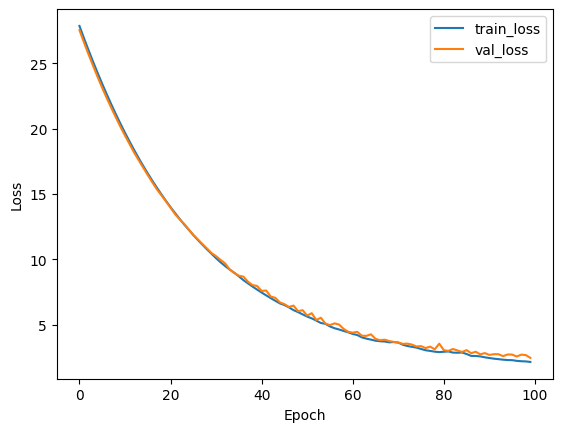

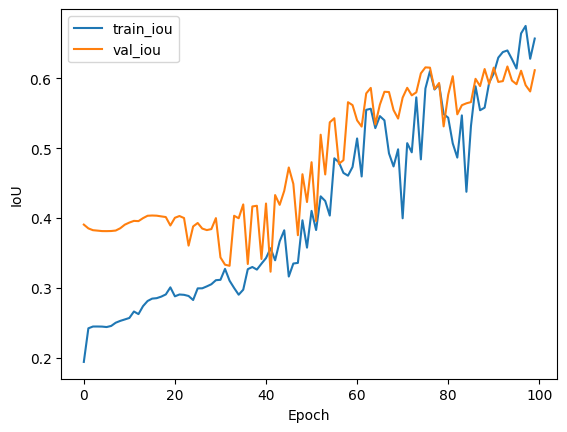

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['iou_metric'], label='train_iou')
plt.plot(history.history['val_iou_metric'], label='val_iou')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

Print Model Architecture

In [29]:
model_path = "/content/unet_model.h5"
input_shape = (64, 64, 15)
num_classes = 1

print("\nModel Architecture Summary:")
model.summary()


Model Architecture Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      8,704 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 256) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 23,369,477 (89.15 MB)

 Trainable params: 7,789,825 (29.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,579,652 (59.43 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


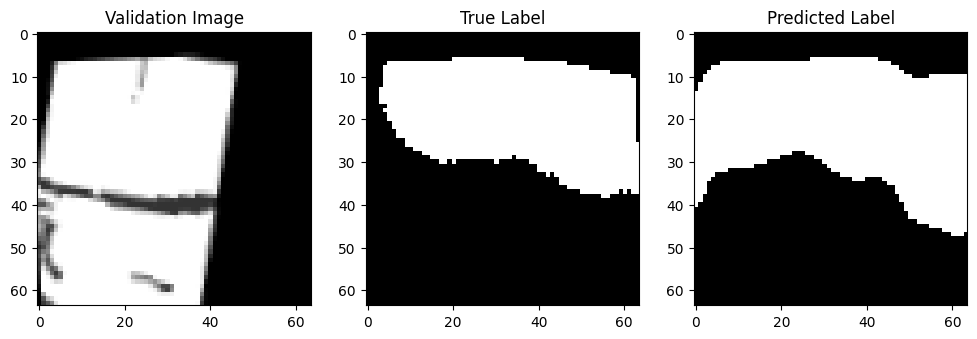

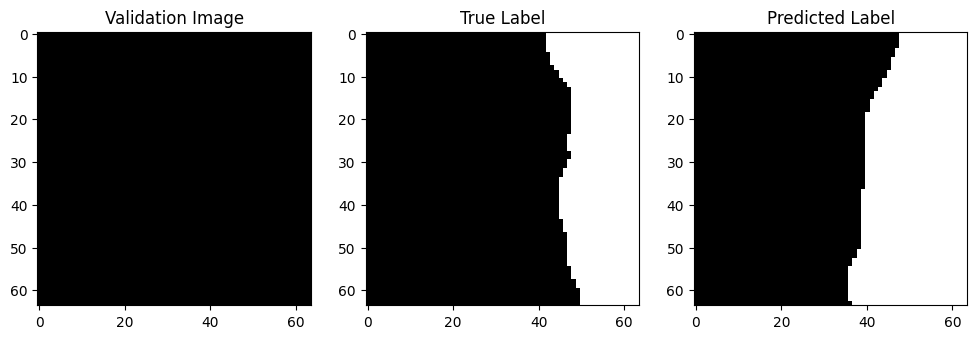

In [37]:
val_preds = model.predict(X_val[:5])
for i in range(2):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    plt.title("Validation Image")
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i, :, :, 0], cmap='gray')
    plt.title("True Label")
    plt.subplot(1, 3, 3)
    plt.imshow(val_preds[i, :, :, 0] > 0.5, cmap='gray')
    plt.title("Predicted Label")
    plt.show()

Save final model

In [38]:
model.save("unet_model_final.h5")
print("Model saved as unet_model_final.h5")

Model saved as unet_model_final.h5


Apply Model to Full Scene

In [39]:
# Inference function
def predict_patch(patch, model, max_value):
    patch = patch / max_value if max_value > 0 else patch
    patch = np.clip(patch, 0, 1)
    patch = np.expand_dims(patch, axis=0)  # Add batch dimension
    pred = model.predict(patch, verbose=0)
    return pred[0, :, :, 0]  # Shape: (64, 64)

def predict_full_raster(image_path, model, patch_size=64, output_path="prediction_map.tif"):
    with rasterio.open(image_path) as src:
        X = src.read().transpose((1, 2, 0))  # Shape: (height, width, bands)
        meta = src.meta
        height, width = X.shape[:2]

    # Initialize output array
    prediction = np.zeros((height, width), dtype=np.float32)
    counts = np.zeros((height, width), dtype=np.float32)  # Track overlaps

    # Compute max value for normalization
    max_value = np.max(X) if np.max(X) > 0 else 1.0

    # Predict on patches
    for i in range(0, height - patch_size + 1, patch_size // 2):  # Overlap by half patch
        for j in range(0, width - patch_size + 1, patch_size // 2):
            X_patch = X[i:i+patch_size, j:j+patch_size]
            if X_patch.shape == (patch_size, patch_size, X.shape[-1]):
                pred_patch = predict_patch(X_patch, model, max_value)
                prediction[i:i+patch_size, j:j+patch_size] += pred_patch
                counts[i:i+patch_size, j:j+patch_size] += 1

    # Average overlapping predictions
    prediction = np.where(counts > 0, prediction / counts, 0)

    # Save prediction as GeoTIFF
    meta.update(count=1, dtype=rasterio.float32, compress='lzw')
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(prediction, 1)
    print(f"Prediction map saved as {output_path}")

# Predict on full raster
predict_full_raster("/content/Composite.tif", model, output_path="prediction_map.tif")

<ipython-input-39-51b2eefe5aee>:32: RuntimeWarning: invalid value encountered in divide
  prediction = np.where(counts > 0, prediction / counts, 0)


Prediction map saved as prediction_map.tif
